# Project 2:  Kaggle Challenge - Ames Iowa Housing Data Set

## Problem Statement

What is the best regression model, with an **upper limit of 30 variables**, that can predict house sale price in Ames Iowa to a **RMSE of less than $40,000** and what are its **top 3 influencing factors**.

## Executive Summary

The objective of this project is to create the best regression model to predict housing sale price in Ames, with the goals as stated in the problem statement. The data provided are one set of training data, one set of test data and one set of submission example. 

Within the training data and test data are 80 variables of different types and datatypes. The training data has one extra column of `Saleprice` for training purposes. Both data require data cleaning and imputation for missing data.

After a careful process of selection and modelling, the **lasso** model is found to be the most suitable model which fits our objectives. The top 3 influencing factors are **Overall material and finish quality** (overall_qual), **Above grade (ground) living area in square feet** (gr_liv_area) and **Size of garage in square feet** (garage_area).

## Sections

- [Import and clean Train data](#Import-and-clean-Train-data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Import and clean Test data](#Import-and-clean-Test-data)
- [Model preprocessing](#Model-preprocessing)
- [Modelling](#Modelling)
    - [Baseline Model](#Creating-Baseline-score)
    - [Lasso Model](#Creating-Lasso-model)
    - [Ridge Model](#Creating-Ridge-model)
    - [Elastic Net Model](#Creating-Elastic-Net-model)
- [Model Selection](#Model-Selection)
- [Generate Submission data](#Generate-Submission-data)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Data Dictionary](#Annex-A---Data-dictionary)

### Import libraries

In [1141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it

from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

%matplotlib inline

##  Import and clean Train data

### Import and review data

In [1142]:
# Import training data
df_train = pd.read_csv('../datasets/train.csv', keep_default_na=False)
# Initial inspection of training data
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


In [1143]:
# Define function to rename columns
def rename_cols(df):
    df.columns = [col.replace(' ', '_') for col in df.columns.str.lower()]

In [1144]:
# Rename columns
rename_cols(df_train)

In [1145]:
# View dataframe shape
df_train.shape

(2051, 81)

In [1146]:
# Confirm new column names
df_train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


In [1147]:
# View datatypes
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2198.0,2930.0
pid,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,907180080.0,924152030.0
ms_subclass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,70.0,190.0
lot_area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,11513.5,159000.0
overall_qual,2051.0,6.112140e+00,1.426271e+00,1.0,5.0,6.0,7.0,10.0
overall_cond,2051.0,5.562165e+00,1.104497e+00,1.0,5.0,5.0,6.0,9.0
year_built,2051.0,1.971709e+03,3.017789e+01,1872.0,1953.5,1974.0,2001.0,2010.0
year_remod/add,2051.0,1.984190e+03,2.103625e+01,1950.0,1964.5,1993.0,2004.0,2010.0
1st_flr_sf,2051.0,1.164488e+03,3.964469e+02,334.0,879.5,1093.0,1405.0,5095.0
2nd_flr_sf,2051.0,3.293291e+02,4.256710e+02,0.0,0.0,0.0,692.5,1862.0


**COMMENT**

Due to import method, null values are converted to empty strings `''`. Certain columns are erroneously converted to `object` dtype due to their null values becoming `''`. After comparing dataframe against the dictionary, certain nominal variables can be converted to ordinal or binary variables.

In [1148]:
# Define function to convert all columns to appropriate dtypes
def convert_dtypes(df):
    ## Change ms_subclass and pid dtype to str
    df['ms_subclass'] = df['ms_subclass'].astype(str)
    df['pid'] = df['pid'].astype(str)
    
    ## define columns to convert to numeric
    to_float = ['lot_frontage', 'lot_area', 'year_built',
               'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1',
               'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
               '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
               'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
               'full_bath', 'half_bath', 'bedroom_abvgr',
               'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces',
               'garage_yr_blt', 'garage_cars', 'garage_area',
                'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
                '3ssn_porch', 'screen_porch', 'pool_area',
                'misc_val', 'mo_sold', 'yr_sold']       
    for col in to_float:
        df[col] = pd.to_numeric(df[col])
    
    ## convert nominal columns to ordinal
    df['lot_shape'] = df['lot_shape'].map({'IR3': 0,
                                           'IR2': 1,
                                           'IR1': 2,
                                           'Reg': 3})
    
    df['utilities'] = df['utilities'].map({'ELO': 0,
                                           'NoSeWa': 1,
                                           'NoSewr': 2,
                                           'AllPub': 3})
    
    df['land_slope'] = df['land_slope'].map({'Gtl': 0,
                                             'Mod': 1,
                                             'Sev': 2})
    
    df['exter_qual'] = df['exter_qual'].map({'Po': 0,
                                             'Fa': 1,
                                             'TA': 2,
                                             'Gd': 3,
                                             'Ex': 4})

    df['exter_cond'] = df['exter_cond'].map({'Po': 0,
                                             'Fa': 1,
                                             'TA': 2,
                                             'Gd': 3,
                                             'Ex': 4})
    
    df['bsmt_qual'] = df['bsmt_qual'].map({'NA': 0,
                                           'Po': 1,
                                           'Fa': 2,
                                           'TA': 3,
                                           'Gd': 4,
                                           'Ex': 5})
    
    df['bsmt_cond'] = df['bsmt_cond'].map({'NA': 0,
                                           'Po': 1,
                                           'Fa': 2,
                                           'TA': 3,
                                           'Gd': 4,
                                           'Ex': 5})

    df['bsmt_exposure'] = df['bsmt_exposure'].map({'NA': 0,
                                                   'No': 1,
                                                   'Mn': 2,
                                                   'Av': 3,
                                                   'Gd': 4})
    
    df['bsmtfin_type_1'] = df['bsmtfin_type_1'].map({'NA': 0,
                                                     'Unf': 1,
                                                     'LwQ': 2,
                                                     'Rec': 3,
                                                     'BLQ': 4,
                                                     'ALQ': 5,
                                                     'GLQ': 6})
    
    df['bsmtfin_type_2'] = df['bsmtfin_type_2'].map({'NA': 0,
                                                     'Unf': 1,
                                                     'LwQ': 2,
                                                     'Rec': 3,
                                                     'BLQ': 4,
                                                     'ALQ': 5,
                                                     'GLQ': 6})
    df['heating_qc'] = df['heating_qc'].map({'Po': 0,
                                             'Fa': 1,
                                             'TA': 2,
                                             'Gd': 3,
                                             'Ex': 4})
    
    df['electrical'] = df['electrical'].map({'Mix': 0,
                                             'FuseP': 1,
                                             'FuseF': 2,
                                             'FuseA': 3,
                                             'SBrkr': 4})
    
    df['kitchen_qual'] = df['kitchen_qual'].map({'Po': 0,
                                                 'Fa': 1,
                                                 'TA': 2,
                                                 'Gd': 3,
                                                 'Ex': 4})
    
    df['functional'] = df['functional'].map({'Sal': 0,
                                             'Sev': 1,
                                             'Maj2': 2,
                                             'Maj1': 3,
                                             'Mod': 4,
                                             'Min2': 5,
                                             'Min1': 6,
                                             'Typ' : 7})
    
    df['fireplace_qu'] = df['fireplace_qu'].map({'NA': 0,
                                                 'Po': 1,
                                                 'Fa': 2,
                                                 'TA': 3,
                                                 'Gd': 4,
                                                 'Ex': 5})
    
    df['garage_finish'] = df['garage_finish'].map({'NA': 0,
                                                   'Unf': 1,
                                                   'RFn': 2,
                                                   'Fin': 3})
    
    df['garage_qual'] = df['garage_qual'].map({'NA': 0,
                                               'Po': 1,
                                               'Fa': 2,
                                               'TA': 3,
                                               'Gd': 4,
                                               'Ex': 5})
    
    df['garage_cond'] = df['garage_cond'].map({'NA': 0,
                                               'Po': 1,
                                               'Fa': 2,
                                               'TA': 3,
                                               'Gd': 4,
                                               'Ex': 5})
    
    df['paved_drive'] = df['paved_drive'].map({'N': 0,
                                               'P': 1,
                                               'Y': 2})
    
    df['pool_qc'] = df['pool_qc'].map({'NA': 0,
                                       'Fa': 1,
                                       'TA': 2,
                                       'Gd': 3,
                                       'Ex': 4})
    
    df['fence'] = df['fence'].map({'NA': 0,
                                   'MnWw': 1,
                                   'GdWo': 2,
                                   'MnPrv': 3,
                                   'GdPrv': 4})

    ## convert nominal columns to binary
    df['central_air'] = df['central_air'].map({'N': 0,
                                               'Y': 1})

### Convert datatypes

In [1149]:
convert_dtypes(df_train)

**COMMENT**

After the above method, columns converted back to `float` type have their `''` converted to `NaN` values. Similarly for columns converted from nominal to ordinal types, any values that falls outside the allowable ones will become `NaN`.

## Exploratory Data Analysis

#### Evaluate saleprice distribution

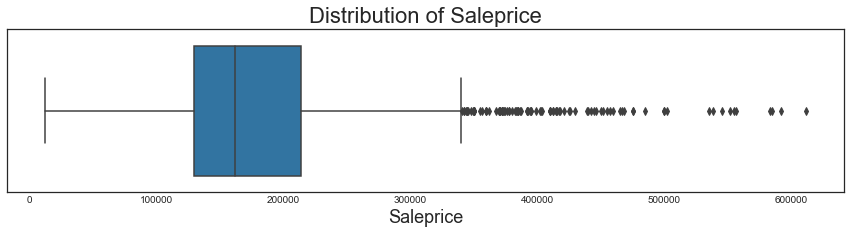

In [1150]:
plt.figure(figsize=(15,3))
sns.boxplot(x= df_train['saleprice'], orient='h');
plt.title('Distribution of Saleprice', fontsize = 22)
plt.xlabel('Saleprice',fontsize=18);

In [1151]:
df_train[['saleprice']].describe()

,saleprice
count,2051.000000
mean,181469.701609
std,79258.659352
min,12789.000000
25%,129825.000000
50%,162500.000000
75%,214000.000000
max,611657.000000


In [1152]:
162500 + (5*79258.659352) # Value at 5 standard deviations above median

558793.29676

**Comment**

Based on the calculation above, we can arbitarily set a limit of $550,000 and regard any entry above this value to be outliers. These outliers will be removed to prevent skewing the modelling.

In [1153]:
df_train = df_train[(df_train['saleprice'] < 550000)]

#### Split variables into different lists based on types

In [1154]:
# Define ordinal variables
ord_cols = ['lot_shape', 'utilities', 'land_slope',
            'overall_qual', 'overall_cond', 'exter_qual',
            'exter_cond', 'bsmt_qual', 'bsmt_cond',
            'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2',
            'heating_qc', 'central_air', 'electrical', 
            'kitchen_qual', 'functional', 'fireplace_qu', 
            'garage_finish', 'garage_qual', 'garage_cond', 
            'paved_drive', 'pool_qc', 'fence']

In [1155]:
# Define nominal variables
nom_cols = [col for col in df_train.columns if df_train[col].dtype == np.object]

In [1156]:
# Define numerical columns.
num_cols = list(df_train.drop(['id'] + ord_cols + nom_cols,axis=1).columns)

In [1157]:
# Verify all variables are accounted for
len(['id'] + ord_cols + nom_cols + num_cols)

81

#### Evaluate numerical variables

In [1158]:
# View percentage of null values, sorted from highest to lowest
df_train[num_cols].isnull().mean().sort_values(ascending=False).head()

lot_frontage      0.161448
garage_yr_blt     0.055773
mas_vnr_area      0.010763
bsmt_half_bath    0.000978
bsmt_full_bath    0.000978
dtype: float64

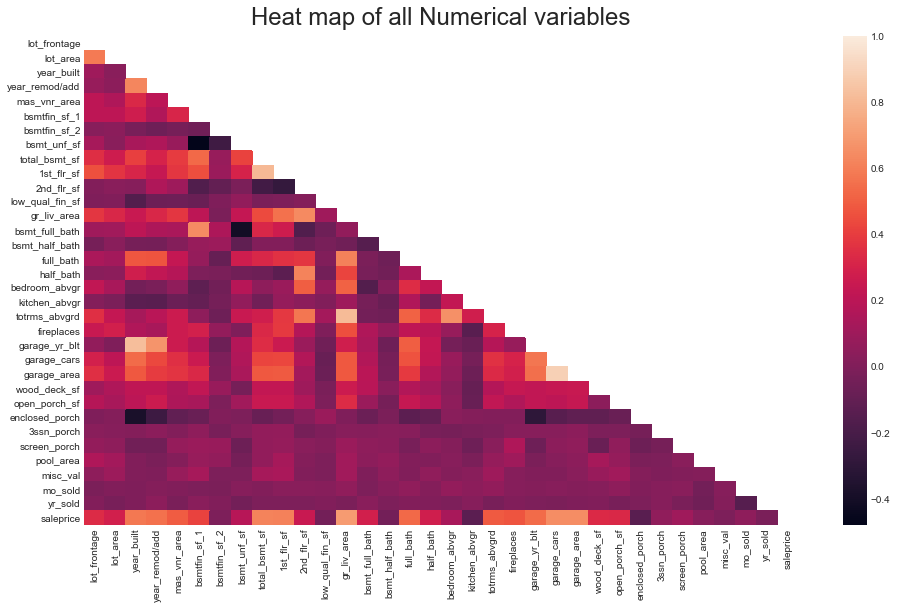

In [1159]:
# Plot correlation heatmap of numerical variables
plt.style.use('seaborn-white')
plt.figure(figsize=(16,9))
mask_size = len(num_cols)
mask = np.zeros((mask_size,mask_size))
mask[np.triu_indices_from(mask)] = True

plt.title('Heat map of all Numerical variables',size=24, y=1.01)
sns.heatmap(df_train[num_cols].corr(),mask=mask);

In [1160]:
# Find collinear variables
df_corr = df_train[num_cols].drop(columns='saleprice',axis=1).corr()
df_corr.stack()[(df_corr.stack() > 0.6) & (df_corr.stack() < 1)].drop_duplicates().sort_values(ascending=False)

garage_cars     garage_area       0.892951
year_built      garage_yr_blt     0.824603
gr_liv_area     totrms_abvgrd     0.810453
total_bsmt_sf   1st_flr_sf        0.804157
year_remod/add  garage_yr_blt     0.672759
bedroom_abvgr   totrms_abvgrd     0.660571
bsmtfin_sf_1    bsmt_full_bath    0.646153
2nd_flr_sf      gr_liv_area       0.641396
year_built      year_remod/add    0.627660
2nd_flr_sf      half_bath         0.615997
gr_liv_area     full_bath         0.612622
dtype: float64

**Comment**

Based on the heatmap and the table above, there are several variables which are collinear. For this project, we will set a threshold of 0.60 for colllinearity. Using this threshold, the variables which fit the criteria are as below, arranged by level of correlation (Strongest to weakest) For each pair, we will pick one (in **bold**) to represent both of them.

|Variable pair|Reason|
|:--|:--|
|(garage_cars, **garage_area**)|garage_area provides more granularity compared to garage_cars|
|(**year_built**, garage_yr_blt)|Logically speaking, the garage would typically be built at the same time when the house was build|
|(**gr_liv_area**, totrms_abvgrd)|Above grade(ground) living area (gr_liv_area) provides more granularity compared to Total rooms above grade (totrms_abvgrd)|
|(total_bsmt_sf, **1st_flr_sf**)| Typically, the first level is given more consideration compared to the basement area.|
|(year_remod/add, garage_yr_blt)| None, as one of the variables are already represented in one of the variable pairs with stronger correlation|
|(bedroom_abvgr, **totrms_abvgrd**)| Total rooms above ground would include the bedrooms above ground|
|(**bsmtfin_sf_1**, bsmt_full_bath)| bsmtfin_sf_1  provides more granularity compared to bsmt_full_bath|
|(2nd_flr_sf, gr_liv_area)|None, as one of the variables are already represented in one of the variable pairs with stronger correlation|
|(year_built, year_remod/add)|None, as one of the variables are already represented in one of the variable pairs with stronger correlation|
|(gr_liv_area, full_bath) |None, as one of the variables are already represented in one of the variable pairs with stronger correlation|
|(**2nd_flr_sf**, half_bath) |2nd_flr_sf  provides more granularity compared to half_bath|

In [1161]:
# Arrange variables based on correlation strength
df_train[num_cols].corr()['saleprice'].sort_values(ascending=False)

saleprice          1.000000
gr_liv_area        0.694004
garage_cars        0.652063
garage_area        0.649764
total_bsmt_sf      0.618054
1st_flr_sf         0.608410
year_built         0.579598
year_remod/add     0.558335
garage_yr_blt      0.541239
full_bath          0.537850
mas_vnr_area       0.496841
totrms_abvgrd      0.489850
fireplaces         0.470728
bsmtfin_sf_1       0.421235
lot_frontage       0.337927
wood_deck_sf       0.330747
open_porch_sf      0.329501
bsmt_full_bath     0.287160
lot_area           0.285397
half_bath          0.278992
2nd_flr_sf         0.253362
bsmt_unf_sf        0.186420
bedroom_abvgr      0.137056
screen_porch       0.107132
3ssn_porch         0.052787
mo_sold            0.048824
pool_area          0.025292
misc_val          -0.006106
bsmtfin_sf_2      -0.007825
yr_sold           -0.019185
low_qual_fin_sf   -0.041564
bsmt_half_bath    -0.042897
kitchen_abvgr     -0.127519
enclosed_porch    -0.135140
Name: saleprice, dtype: float64

**Comment**

Based on the table above, the variables which are determined to be strongly correlated (>0.5) to the sale price, after eliminating those that were identified to be collinear are:

| Variable| Correlation to sale price|
|---|---|
|gr_liv_area|0.694004|
|garage_area|        0.649764|
|1st_flr_sf|        0.608410|
|year_built|         0.579598|

In [1162]:
chosen_num_var = ['gr_liv_area','garage_area','1st_flr_sf','year_built']

#### Evaluate chosen numerical variables

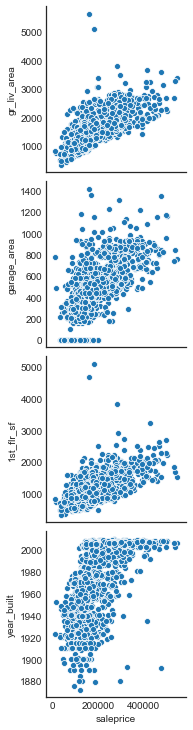

In [1163]:
# Plot scatter plot of chosen numerical variables and saleprice
sns.pairplot(df_train, y_vars=chosen_num_var,x_vars=['saleprice']);

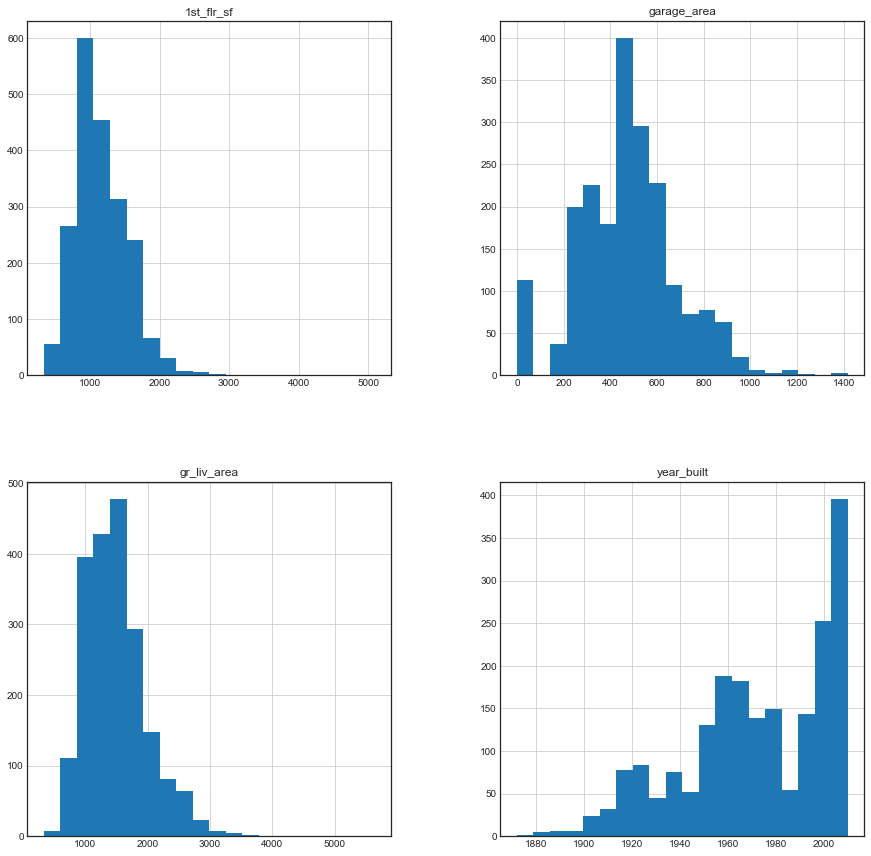

In [1164]:
# Plot histograms of chosen numerical variables
df_train[chosen_num_var].hist(figsize=(15,15),bins=20);

**Comment**

The histograms above indicate that chosen numerical variables are mostly normally distributed, though `year_built` is skewed  to the left.

####  Evaluate nominal variables

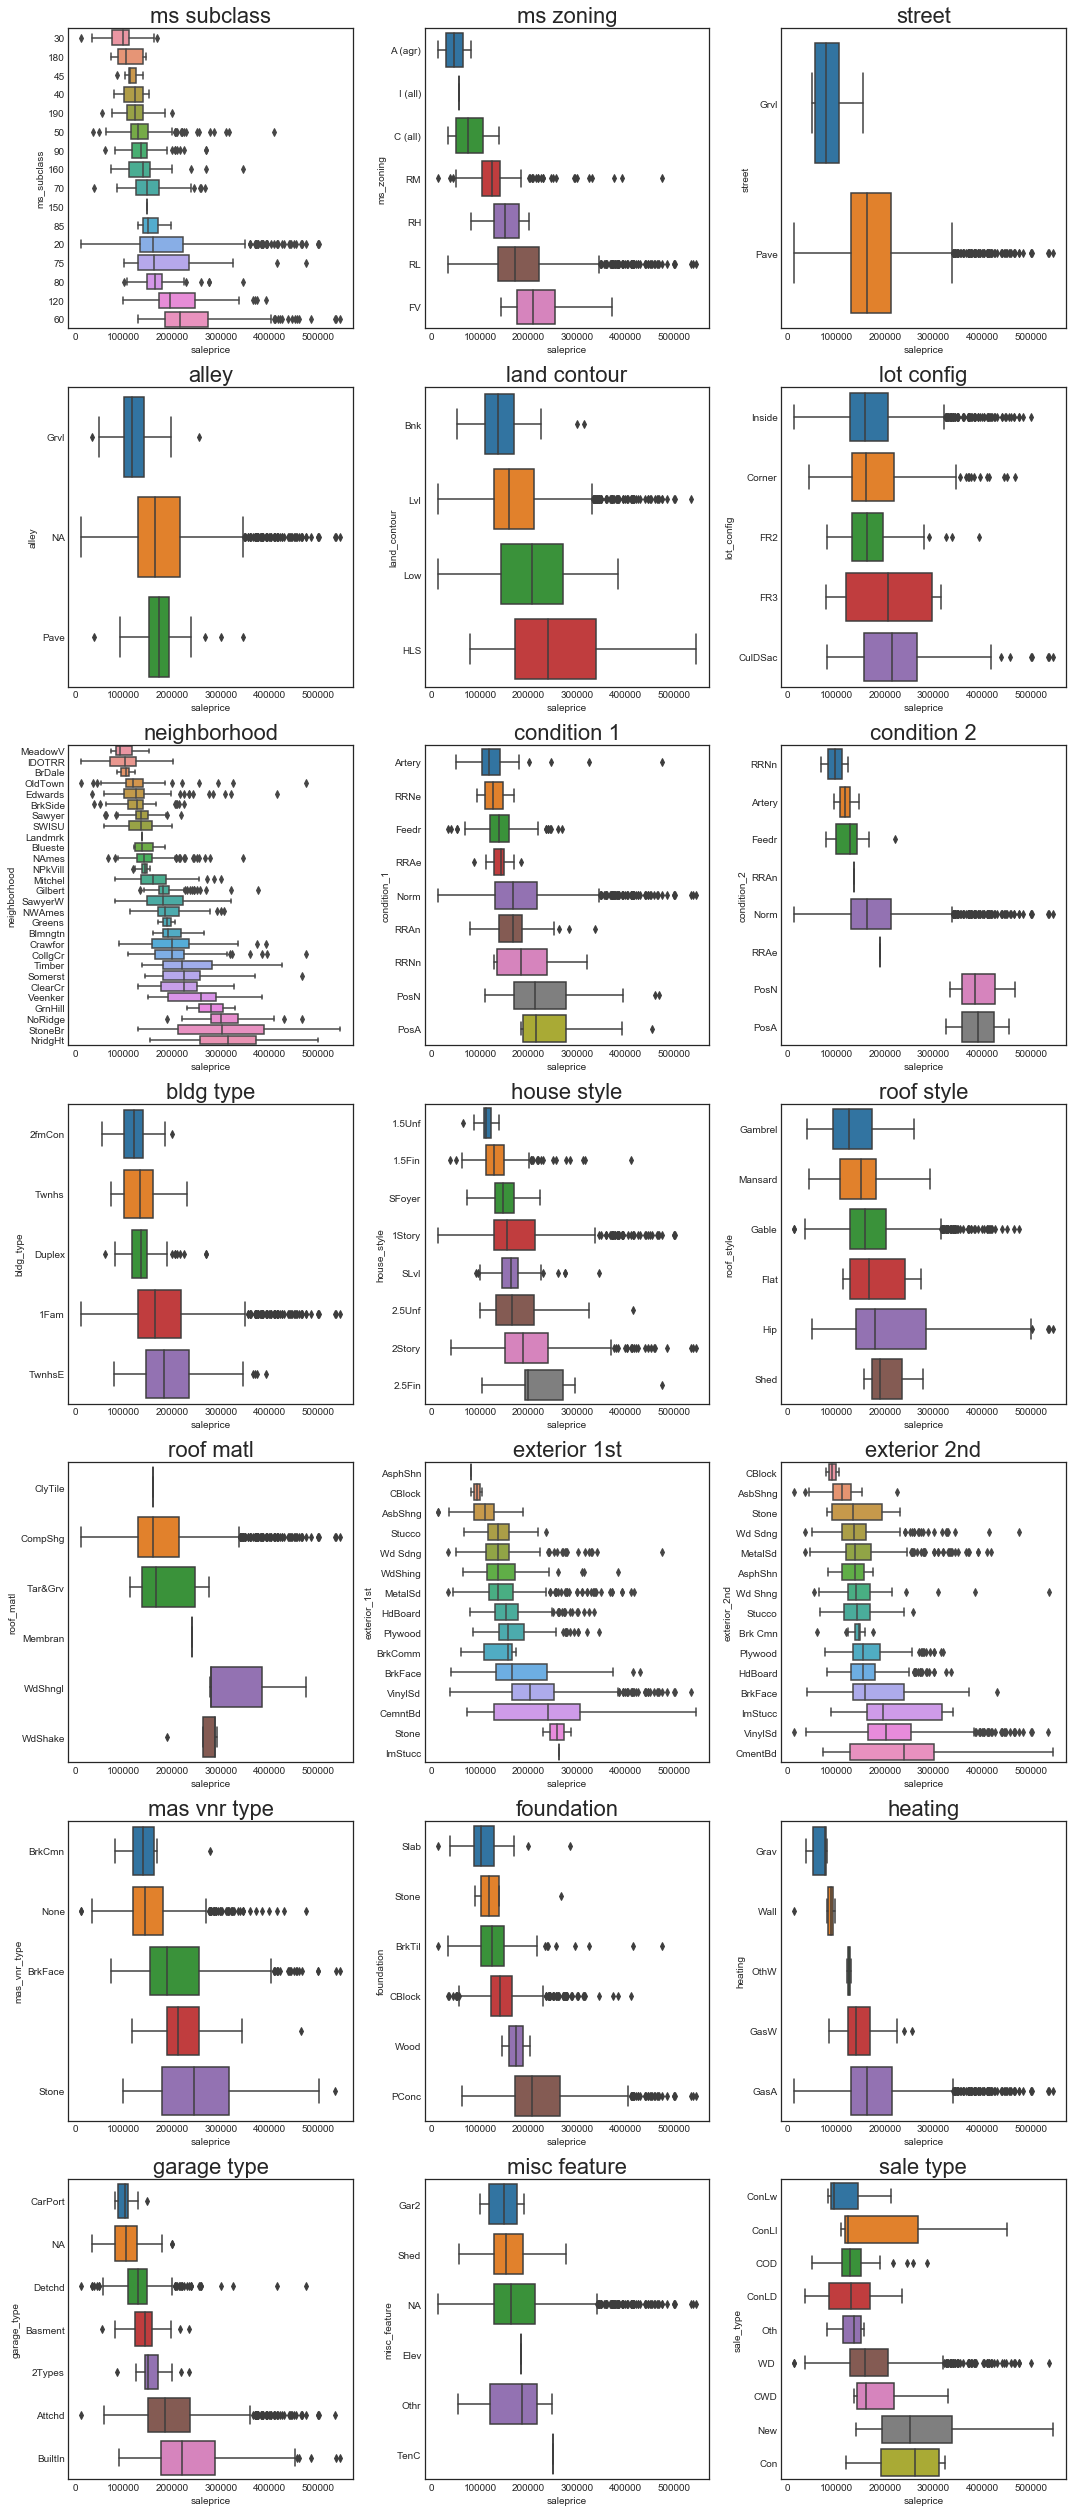

In [1165]:
# Plot boxplots of all nominal variables
boxplot_var = nom_cols[1::] # exclude 'pid'

n=len(boxplot_var)

n_cols = 3
n_rows = round((n/n_cols))

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*5))
ax = ax.ravel()

for i, var in enumerate(boxplot_var):

    sns.boxplot(y=var, 
                order = list(df_train.groupby(var)['saleprice'].median().sort_values().index),
                x= "saleprice",
                data=df_train,  
                orient='h', 
                ax=ax[i])
    ax[i].set_title(var.replace("_",' '), fontsize = 22)

plt.tight_layout()

The selection criteria for nominal variables is that the each unique value has its own unique `saleprice` distribution.

Based on this criteria, the following variables are selected.

In [1166]:
chosen_nom_var = ['ms_zoning','street','land_contour','foundation','heating','garage_type']

#### Evalute ordinal variables

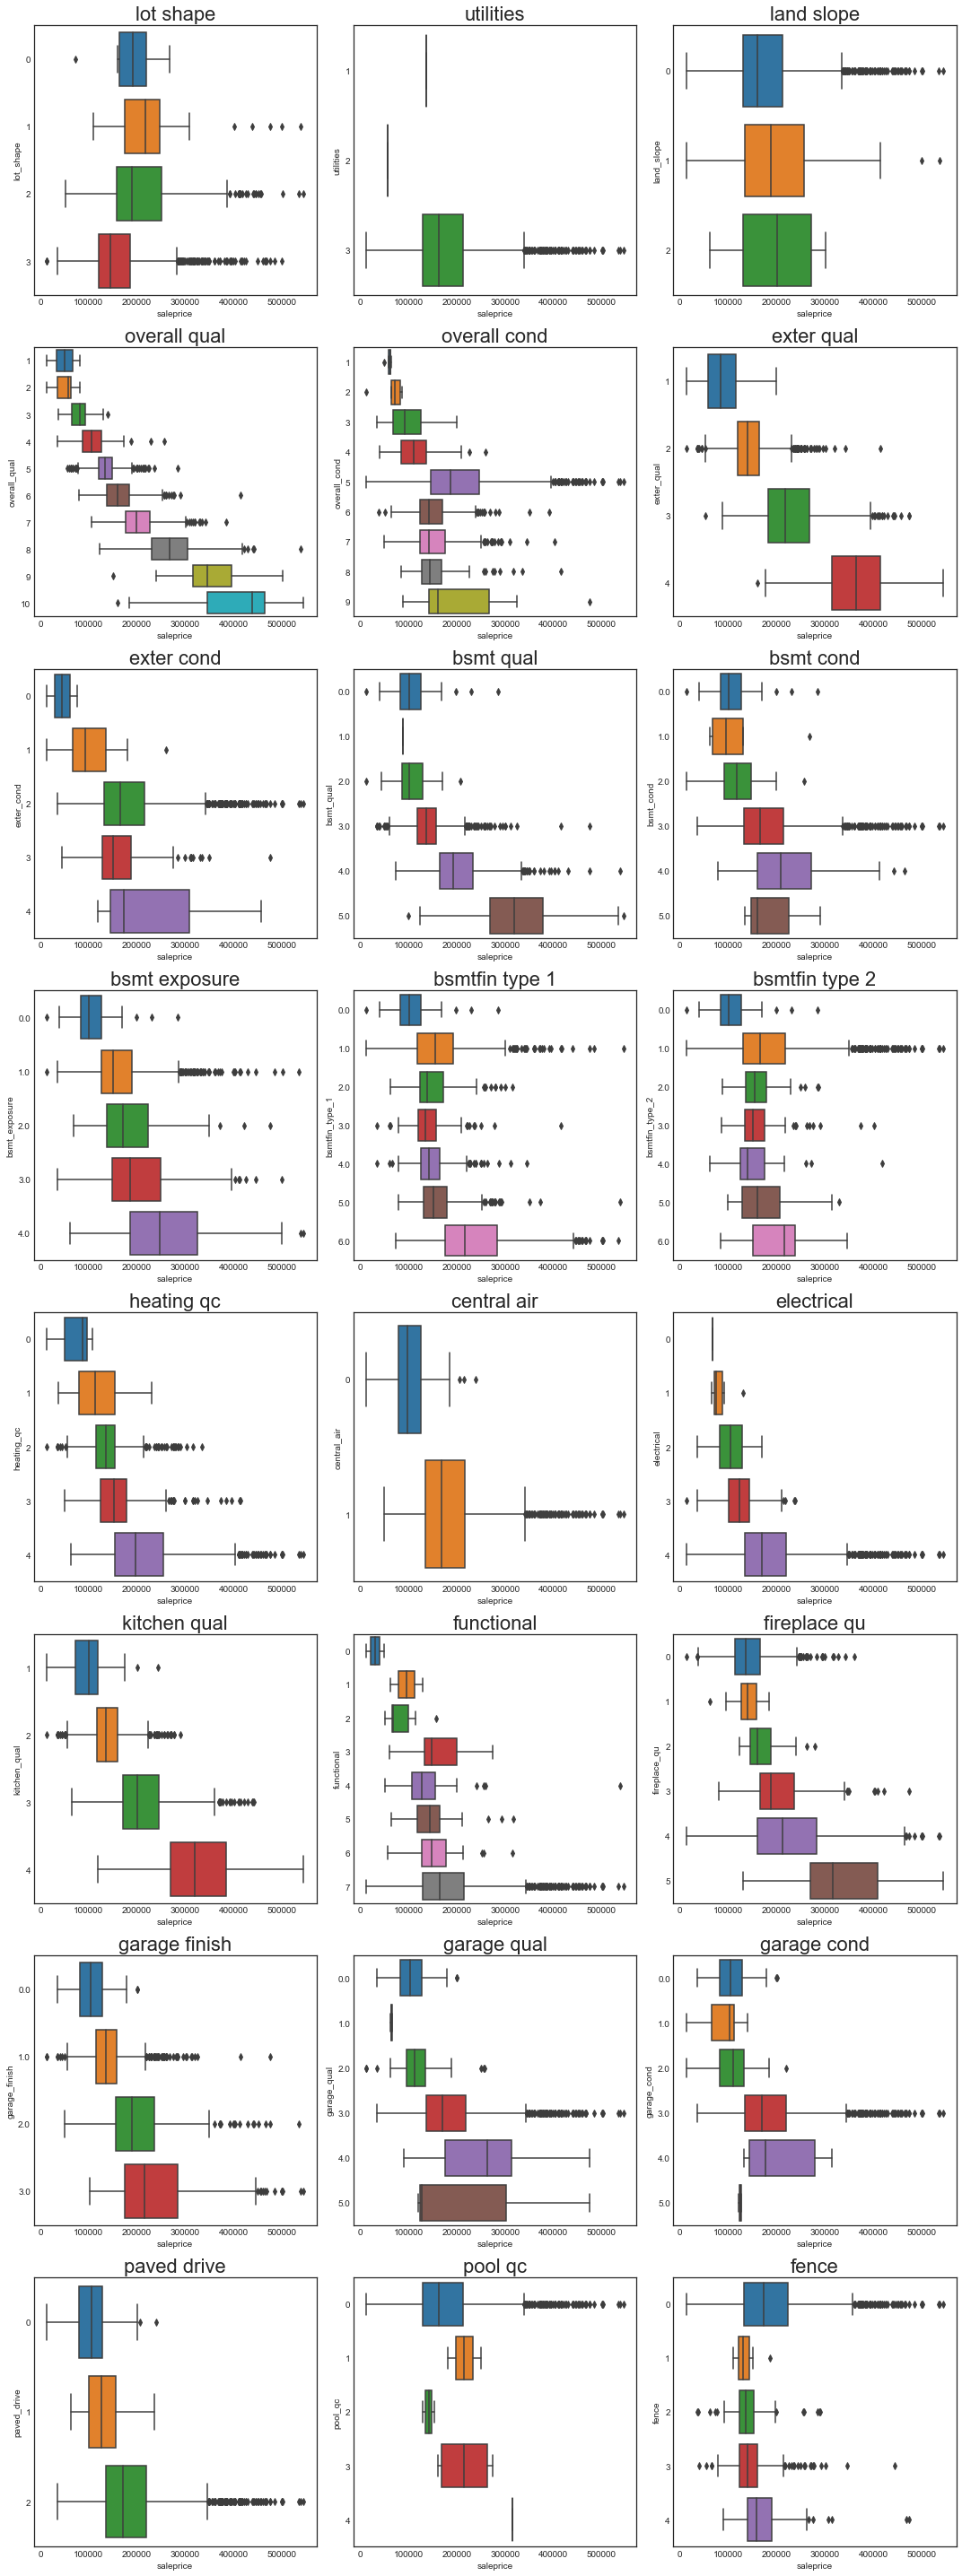

In [1167]:
# Plot boxplot of all ordinal variables
boxplot_var = ord_cols

n=len(boxplot_var)

n_cols = 3
n_rows = round((n/n_cols))

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*5))
ax = ax.ravel()

for i, var in enumerate(boxplot_var):
   

    sns.boxplot(y=var,
                x= "saleprice",
                data=df_train,  
                orient='h', 
                ax=ax[i])
    ax[i].set_title(var.replace("_",' '), fontsize = 22)

plt.tight_layout()

The selection criteria for ordinal variables is similar to that of nominal variables, that each unique value has its own unique `saleprice` distribution. On top of that, we are going to evaluate the spearman coefficient, which requires a monotonic relationship [(reference link)](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php/).

Based on these criterias, the following variables are selected.

In [1168]:
chosen_ord_var = ['overall_qual', 'exter_qual', 'bsmt_exposure', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'garage_finish', 'paved_drive']

#### Evalute chosen ordinal variables

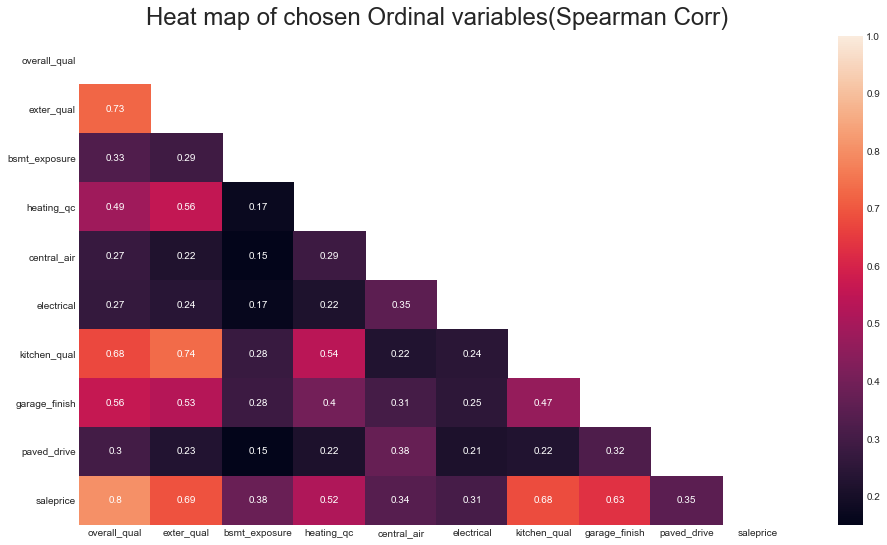

In [1169]:
# Plot correlation heatmap of numerical variables
plt.style.use('seaborn-white')
plt.figure(figsize=(16,9))
mask_size = len(chosen_ord_var+['saleprice'])
mask = np.zeros((mask_size,mask_size))
mask[np.triu_indices_from(mask)] = True

plt.title('Heat map of chosen Ordinal variables(Spearman Corr)',size=24, y=1.01)
sns.heatmap(df_train[chosen_ord_var+['saleprice']].corr('spearman'),mask=mask, annot=True);

In [1170]:
# Identify the collinear variables
df_corr = df_train[chosen_ord_var].corr('spearman')
df_corr.stack()[(df_corr.stack() > 0.6) & (df_corr.stack() < 1)].drop_duplicates().sort_values(ascending=False)

exter_qual    kitchen_qual    0.737398
overall_qual  exter_qual      0.725613
              kitchen_qual    0.675051
dtype: float64

**Comment**

Based on the above values, there are some variables which are collinear. However, we can observe that they are all mutually related. As such, we can pick `overall_qual` and drop the rest.

In [1171]:
chosen_ord_var.remove('exter_qual')
chosen_ord_var.remove('kitchen_qual')

In [1172]:
# Arrange variables based on correlation strength
df_train[chosen_ord_var + ['saleprice']].corr()['saleprice'].sort_values(ascending=False)

saleprice        1.000000
overall_qual     0.804157
garage_finish    0.565277
heating_qc       0.464270
bsmt_exposure    0.413496
paved_drive      0.298210
central_air      0.285207
electrical       0.254092
Name: saleprice, dtype: float64

**Comment**

Based on the table above, the variables which are determined to be strongly correlated (>0.5) to the sale price, after eliminating those that were identified to be collinear are:

| Variable| Correlation to sale price|
|---|---|
|overall_qual|0.0.804157|
|garage_finish|0.565277|

In [1173]:
chosen_ord_var = ['overall_qual', 'garage_finish']

### Feature Engineering: Imputation

In [1174]:
# Define function to impute missing variables
def impute_train(df):
    df_copy = df.copy()
    impute_val = {}
    for col in df_copy.columns:
        if col == 'id' or col == 'pid':
            continue
        # Check if numerical or ordinal variables
        if col in num_cols or col in ord_cols:
            # Check if numerical variables
            if  col not in ord_cols:
                impute_val.update({col:df_copy[col].mean()})
                # Check if column contains any null values
                if df_copy[col].isnull().any():
                    # Impute column mean for numerical variables
                    df_copy[col].fillna(df_copy[col].mean(),inplace=True)
            else:
                impute_val.update({col:df_copy[col].mode()[0]})
                # Check if column contains any null values
                if df_copy[col].isnull().any():
                    # Impute column mode for ordinal variables
                    df_copy[col].fillna(df_copy[col].mode()[0],inplace=True)
                    
        # Check if nominal variables
        else:
            impute_val.update({col:df_copy[col].mode()[0]})
            # Check if column contains any empty strings
            if len(df_copy[df_copy[col]=='']) != 0:
                # Impute column mode                
                df_copy[col].replace('',df_copy[col].mode()[0],inplace=True)
                
    return df_copy, impute_val

In [1175]:
# Impute for missing values and capture imputed values
df_train_imp, train_impute_vals = impute_train(df_train)

In [1176]:
df_train_imp.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,68.950408,13517,Pave,NA,2,Lvl,...,0,0,0,0,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.000000,11492,Pave,NA,2,Lvl,...,0,0,0,0,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.000000,7922,Pave,NA,3,Lvl,...,0,0,0,0,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.000000,9802,Pave,NA,3,Lvl,...,0,0,0,0,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.000000,14235,Pave,NA,2,Lvl,...,0,0,0,0,NA,0,3,2010,WD,138500


In [1177]:
# Create dataframe with variables of interest only
df_train_eval = df_train_imp[chosen_num_var+chosen_nom_var+chosen_ord_var]

### Feature Engineering: One hot encoding

In [1178]:
# Get dummy columns and drop original columns
for col in chosen_nom_var:
    df_train_eval = pd.concat([df_train_eval, pd.get_dummies(df_train_eval[col],prefix=col)], axis=1)
    df_train_eval.drop(columns=col,axis=1,inplace=True)

### Feature Engineering: Interaction terms

In [1179]:
num_cols_combi = num_cols.copy()
num_cols_combi.remove('saleprice')

In [1180]:
# Use itertools to get all possible combinations
df_inter = pd.DataFrame()
for combi in list(it.combinations(num_cols_combi,2)):
    df_inter[f'{combi[0]}*{combi[1]}'] = df_train_imp[combi[0]] * df_train_imp[combi[1]]
    df_inter[f'{combi[0]}/{combi[1]}'] = df_train_imp[combi[0]] / df_train_imp[combi[1]]
    df_inter[f'{combi[1]}/{combi[0]}'] = df_train_imp[combi[1]] / df_train_imp[combi[0]]

df_inter['saleprice'] = df_train_imp['saleprice']

In [1181]:
# Evaluate correlation of combinations with saleprice
df_inter.corr()['saleprice'].sort_values(ascending=False)[:40]

saleprice                     1.000000
gr_liv_area*garage_cars       0.791186
total_bsmt_sf*garage_cars     0.759452
1st_flr_sf*garage_cars        0.753755
gr_liv_area*garage_area       0.748729
full_bath*garage_area         0.734826
gr_liv_area/kitchen_abvgr     0.723961
full_bath*garage_cars         0.714428
totrms_abvgrd*garage_cars     0.714193
year_built*gr_liv_area        0.713870
totrms_abvgrd*garage_area     0.710074
gr_liv_area/half_bath         0.710053
gr_liv_area*garage_yr_blt     0.707268
year_remod/add*gr_liv_area    0.705142
total_bsmt_sf*full_bath       0.700523
1st_flr_sf*garage_area        0.695236
gr_liv_area/yr_sold           0.694022
gr_liv_area*yr_sold           0.693984
garage_cars*garage_area       0.687770
garage_cars/half_bath         0.685151
gr_liv_area/year_remod/add    0.681954
total_bsmt_sf*garage_area     0.680026
gr_liv_area/garage_yr_blt     0.679396
gr_liv_area*full_bath         0.677360
garage_cars/kitchen_abvgr     0.676680
1st_flr_sf*full_bath     

**Comment**

The variable combinations with the highest correlation all contains chosen numerical variables or their collinear variables. Therefore, there are no valid interaction terms.

##  Import and clean Test data

In [1182]:
df_test = pd.read_csv('../datasets/test.csv', keep_default_na=False)
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,,9662,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58,17104,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60,8520,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,,9500,Pave,NA,IR1,Lvl,...,0,185,0,NA,NA,NA,0,7,2009,WD


In [1183]:
# Rename columns
rename_cols(df_test)

In [1184]:
# Convert columns to appropriate data types
convert_dtypes(df_test)

In [1185]:
# Define function to impute missing variables
def impute_test(df, impute_vals):
    df_copy = df.copy()
    for col in df_copy.columns:
        if col == 'id' or col == 'pid':
            continue
        # Check if numerical or ordinal variables
        if col in num_cols or col in ord_cols:
            # Check if numerical variables
            if  col not in ord_cols:
                
                # Check if column contains any null values
                if df_copy[col].isnull().any():
                    # Impute column mean for numerical variables
                    df_copy[col].fillna(impute_vals[col],inplace=True)
            else:
               
                # Check if column contains any null values
                if df_copy[col].isnull().any():
                    # Impute column mode for ordinal variables
                    df_copy[col].fillna(impute_vals[col],inplace=True)
                    
        # Check if nominal variables
        else:
           
            # Check if column contains any empty strings
            if len(df_copy[df_copy[col]=='']) != 0:
                # Impute column mode                
                df_copy[col].replace('',impute_vals[col],inplace=True)
                
    return df_copy

In [1186]:
# Fill in missing values
df_test_imp = impute_test(df_test, train_impute_vals)

In [1187]:
# Create dataframe with variables of interest only
df_test_eval = df_test_imp[chosen_num_var+chosen_nom_var+chosen_ord_var]

### Feature Engineering: One hot encoding

In [1188]:
# Get dummy columns and drop original columns
for col in chosen_nom_var:
    df_test_eval = pd.concat([df_test_eval, pd.get_dummies(df_test_eval[col],prefix=col)], axis=1)
    df_test_eval.drop(columns=col,axis=1,inplace=True)

In [1189]:
df_test_eval.head()

,gr_liv_area,garage_area,1st_flr_sf,year_built,overall_qual,garage_finish,ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,...,heating_GasA,heating_GasW,heating_Grav,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_NA
0,1928,440,908,1910,6,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1967,580,1967,1977,5,3.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1496,426,664,2006,7,2.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,968,480,968,1923,5,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1394,514,1394,1963,6,2.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


## Model preprocessing

In [1190]:
# Identify predictors common to both train and test datasets
predictors = set(df_train_eval.columns).intersection(set(df_test_eval.columns))

In [1191]:
X = df_train_eval[predictors]
y = df_train['saleprice']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X,y)

### Model pre-processing: Scaling

In [1192]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

## Modelling

### Creating Baseline score

In [1193]:
# Create predictions based on mean price
base_pred = pd.DataFrame(np.full(len(y_test),y.mean()));

In [1194]:
# RMSE
np.sqrt(metrics.mean_squared_error(y_test,base_pred))

79435.83893070737

**Comment**

Root mean squared error is chosen as the metric as this is the metric chosen by the Kaggle challenge

### Creating Lasso model

In [1195]:
lasso = LassoCV(n_alphas=200)
lasso.fit(X_train_scaled, y_train);

In [1196]:
lasso.score(X_test_scaled,y_test)

0.822945181270856

In [1197]:
# R2
cross_val_score(lasso,X_test_scaled,y_test).mean()

0.8123395221786044

In [1198]:
# Get number of variables after regularisation
(lasso.coef_ != 0).sum()

26

In [1199]:
# RMSE
pred = lasso.predict(X_test_scaled)
np.sqrt(metrics.mean_squared_error(y_test,pred))

33414.34311495076

### Creating Ridge model

In [1200]:
ridge = RidgeCV(alphas = np.linspace(0.1,100,200))
ridge.fit(X_train_scaled, y_train);

In [1201]:
ridge.score(X_test_scaled, y_test)

0.8212293456369761

In [1202]:
# R2
cross_val_score(ridge,X_test_scaled,y_test).mean()

0.815121922071747

In [1203]:
# Get number of variables after regularisation
(ridge.coef_ != 0).sum()

33

In [1204]:
# RMSE
pred = ridge.predict(X_test_scaled)
np.sqrt(metrics.mean_squared_error(y_test,pred))

33575.86169277421

### Creating Elastic Net model

In [1205]:
# Using GridSearch for the best parameters
enet_params = {
    'alpha' : np.arange(0.1,1,0.05),
    'l1_ratio' : np.arange(0.1, 1, 0.05),
    'max_iter' : [5000]
}

enet_GS = GridSearchCV(ElasticNet(),
                      enet_params,
                      cv=5,
                      scoring='r2')

In [1206]:
enet_GS.fit(X_train_scaled, y_train);

In [1207]:
enet_GS.best_score_

0.7965183189538786

In [1208]:
best_enet = enet_GS.best_estimator_

In [1209]:
best_enet.score(X_test_scaled,y_test)

0.8215823081001778

In [1210]:
# R2
cross_val_score(best_enet,X_test_scaled,y_test).mean()

0.8130809408285156

In [1211]:
# Get number of variables after regularisation
(best_enet.coef_ != 0).sum()

33

In [1212]:
# RMSE
pred = best_enet.predict(X_test_scaled)
np.sqrt(metrics.mean_squared_error(y_test,pred))

33542.69944280707

## Model Selection

It is observed that every model performs better than the baseline, judging from the improved RMSE score. In terms of R2, each model performs similarly well. However, the Lasso model is able to meet our objective of narrowing down to 30 variables or less. Therefore, Lasso is the selected model.

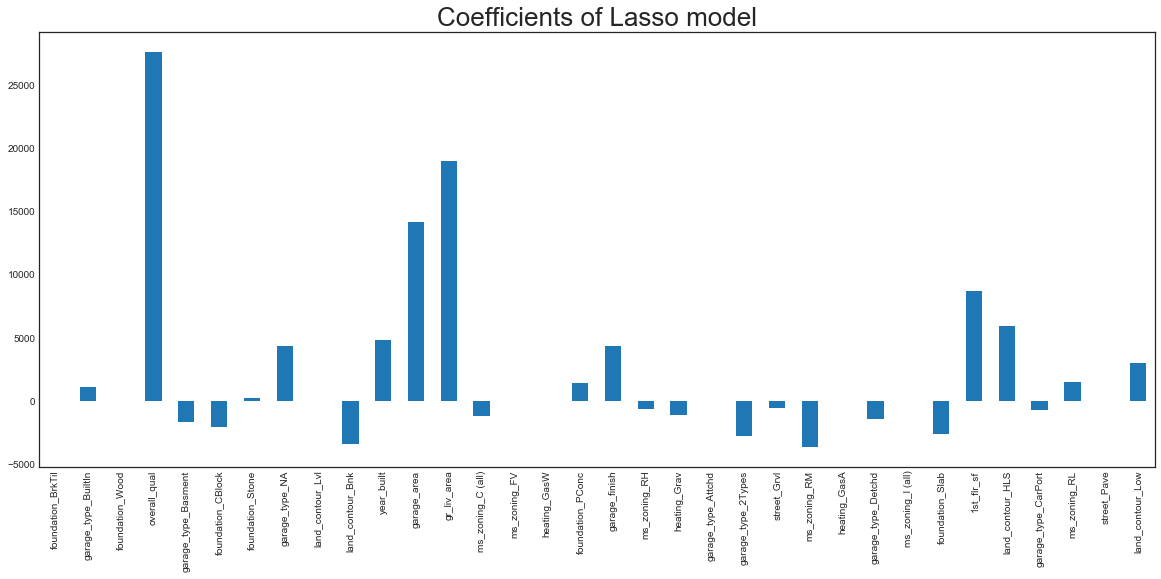

In [1213]:
pd.Series(lasso.coef_, index=predictors).plot.bar(figsize=(20,8));
plt.title('Coefficients of Lasso model',fontsize=26);

In [1214]:
# Show variables with the highest positive coefficients
pd.DataFrame({'Variables':list(predictors),'Coef':lasso.coef_}).sort_values(by='Coef',ascending=False).head()

,Variables,Coef
3,overall_qual,27615.795303
12,gr_liv_area,19026.252478
11,garage_area,14167.231867
28,1st_flr_sf,8748.662387
29,land_contour_HLS,5975.185745


In [1215]:
# Show variables with the lowest negative coefficients
pd.DataFrame({'Variables':list(predictors),'Coef':lasso.coef_}).sort_values(by='Coef').head()

,Variables,Coef
23,ms_zoning_RM,-3634.644405
9,land_contour_Bnk,-3360.849216
21,garage_type_2Types,-2703.611714
27,foundation_Slab,-2568.272675
5,foundation_CBlock,-2070.531788


The bar chart shows that there are certain variables with significant coefficients.

Based on the absolute value of the coefficients, we can determine that Overall material and finish quality (overall_qual), Above grade (ground) living area in square feet (gr_liv_area) and Size of garage in square feet (garage_area) are the top three influencing factors.

## Generate Submission data

In [1216]:
X = df_test_eval[predictors]
X_scaled = ss.transform(X)

In [1217]:
# Predictions
pred = lasso.predict(X_scaled)

In [1218]:
# Create dataframe with submission format
df_sub = pd.DataFrame({'Id': df_test['id'].values, 'SalePrice' : pred})

In [1219]:
# Export to csv
df_sub.to_csv('../datasets/submission.csv', index=False)

### Kaggle submission results

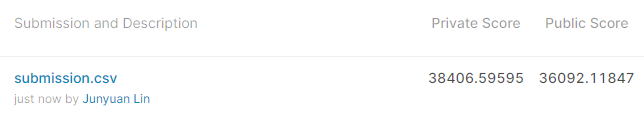

## Conclusions and Recommendations

Through this exercise, it can be observed that though there are many variables available, a number of them are found to be collinear and quite a significant amount could not meet our selection criteria. On the other hand, this helps us to be able to narrow down in order to meet our objective.

In conclusion, the  lasso model was able to fulfil the criteria set out in the problem statement. Its number of predictors are 26, which is less than 30. The Kaggle submission results indicate that the RMSE target is met.

The top three predictors are:
1. Overall material and finish quality (overall_qual)
2. Above grade (ground) living area in square feet (gr_liv_area)
3. Size of garage in square feet (garage_area) are the top three influencing factors

Therefore, homeowners seeking to increase their house value can improve its overall quality, expand the above ground living area or the size of the garage. 

On the other hand, the predictors with the top three negative variables can also provide interesting insight. First of all, they are all drawn from nominal variables, 1. land_contour: Banked, which means that there is a `Quick and significant rise from street grade to building`, 2. garage_type:2Types, which means there is `More than one type of garage` and 3. ms_zoning_:RM, which means its zoning classification is `Residential Medium Density`. Homebuyers seeking lower priced units or people seeking to resell their house should take these factors into consideration. 

###  Annex A - Data dictionary

|     Column      |  Type  | Description                                                  |
| :-------------: | :----: | :----------------------------------------------------------- |
|       id        |  int   | **ID**                                                       |
|       pid       | object | **Property ID Number**                                       |
|   ms_subclass   | object | **The building class** <br> 20 : 1-STORY 1946 & NEWER ALL STYLES <br>30 : 1-STORY 1945 & OLDER<br>40 : 1-STORY W/FINISHED ATTIC ALL AGES<br>45 : 1-1/2 STORY - UNFINISHED ALL AGES<br>50 : 1-1/2 STORY FINISHED ALL AGES<br>60 : 2-STORY 1946 & NEWER<br>70 : 2-STORY 1945 & OLDER<br>75 : 2-1/2 STORY ALL AGES<br>80 : SPLIT OR MULTI-LEVEL<br>85 : SPLIT FOYER<br>90 : DUPLEX - ALL STYLES AND AGES<br>120 : 1-STORY PUD (Planned Unit Development) - 1946 & NEWER<br>150 : 1-1/2 STORY PUD - ALL AGES<br>160 : 2-STORY PUD - 1946 & NEWER<br>180 : PUD - MULTILEVEL - INCL SPLIT LEV/FOYER<br>190 : 2 FAMILY CONVERSION - ALL STYLES AND AGES |
|    ms_zoning    | object | **Identifies the general zoning classification of the sale.**<br>A : Agriculture<br>C : Commercial<br>FV : Floating Village Residential<br>I : Industrial<br>RH : Residential High Density<br>RL : Residential Low Density<br>RP : Residential Low Density Park<br>RM : Residential Medium Density |
|  lot_frontage   | float  | **Linear feet of street connected to property**              |
|    lot_area     |  int   | **Lot size in square feet**                                  |
|     street      | object | **Type of road access to property**<br>Grvl : Gravel<br>Pave : Paved |
|      alley      | object | **Type of alley access to property**<br>Grvl : Gravel<br>Pave : Paved<br>NA : No alley access |
|    lot_shape    |  int   | **LotShape: General shape of property**<br>3 (Reg) : Regular<br>2 (IR1) : Slightly irregular<br>1 (IR2) : Moderately Irregular<br>0 (IR3) : Irregular |
|  land_contour   | object | **LandContour: Flatness of the property**<br>Lvl : Near Flat/Level<br>Bnk : Banked - Quick and significant rise from street grade to building<br>HLS : Hillside - Significant slope from side to side<br>Low Depression |
|    utilities    |  int   | **Type of utilities available**<br>3 (AllPub) : All public Utilities (E,G,W,& S)<br>2 ( NoSewr) : Electricity, Gas, and Water (Septic Tank)<br>1 (NoSeWa) : Electricity and Gas Only<br>0 (ELO) : Electricity only |
|   lot_config    | object | **Lot configuration**<br>Inside : Inside lot<br>Corner : Corner lot<br>CulDSac : Cul-de-sac<br>FR2 : Frontage on 2 sides of property<br>FR3 : Frontage on 3 sides of property |
|   land_slope    |  int   | **Slope of property**<br>2 (Gtl) : Gentle slope<br>1 (Mod) : Moderate Slope<br>0 (Sev) : Severe Slope |
|  neighborhood   | object | **Physical locations within Ames city limits**<br>Blmngtn : Bloomington Heights<br>Blueste : Bluestem<br>BrDale : Briardale<br>BrkSide : Brookside<br>ClearCr : Clear Creek<br>CollgCr : College Creek<br>Crawfor : Crawford<br>Edwards : Edwards<br>Gilbert : Gilbert<br>IDOTRR : Iowa DOT and Rail Road<br>Meadow : Meadow Village<br>Mitchel : Mitchell<br>Names : North Ames<br>NoRidge : Northridge<br>NPkVill : Northpark Villa<br>NridgHt : Northridge Heights<br>NWAmes : Northwest Ames<br>OldTown : Old Town<br>SWISU : South & West of Iowa State University<br>Sawyer : Sawyer<br>SawyerW : Sawyer West<br>Somerst : Somerset<br>StoneBr : Stone Brook<br>Timber : Timberland<br>Veenker : Veenker |
|   condition_1   | object | **Proximity to main road or railroad**<br>Artery : Adjacent to arterial street<br>Feedr : Adjacent to feeder street<br>Norm : Normal<br>RRNn : Within 200' of North-South Railroad<br>RRAn : Adjacent to North-South Railroad<br>PosN : Near positive off-site feature--park, greenbelt, etc.<br>PosA : Adjacent to postive off-site feature<br>RRNe : Within 200' of East-West Railroad<br>RRAe : Adjacent to East-West Railroad |
|   condition_2   | object | **Proximity to main road or railroad (if a second is present)**<br>Artery : Adjacent to arterial street<br>Feedr : Adjacent to feeder street<br>Norm : Normal<br>RRNn : Within 200' of North-South Railroad<br>RRAn : Adjacent to North-South Railroad<br>PosN : Near positive off-site feature--park, greenbelt, etc.<br>PosA : Adjacent to postive off-site feature<br>RRNe : Within 200' of East-West Railroad<br>RRAe : Adjacent to East-West Railroad |
|    bldg_type    | object | **Type of dwelling**<br>1Fam : Single-family Detached<br>2FmCon : Two-family Conversion; originally built as one-family dwelling<br>Duplx : Duplex<br>TwnhsE : Townhouse End Unit<br>TwnhsI : Townhouse Inside Unit |
|   house_style   | object | **Style of dwelling**<br>1Story : One story<br>1.5Fin : One and one-half story: 2nd level finished<br>1.5Unf : One and one-half story: 2nd level unfinished<br>2Story : Two story<br>2.5Fin : Two and one-half story: 2nd level finished<br>2.5Unf : Two and one-half story: 2nd level unfinished<br>SFoyer : Split Foyer<br>SLvl : Split Level |
|  overall_qual   |  int   | **Overall material and finish quality**<br>10 : Very Excellent<br>9 : Excellent<br>8 : Very Good<br>7 : Good<br>6 : Above Average<br>5 : Average<br>4 : Below Average<br>3 : Fair<br>2 : Poor<br>1 : Very Poor |
|  overall_cond   |  int   | **Overall condition rating**<br>10 : Very Excellent<br>9 : Excellent<br>8 : Very Good<br>7 : Good<br>6 : Above Average<br>5 : Average<br>4 : Below Average<br>3 : Fair<br>2 : Poor<br>1 : Very Poor |
|   year_built    |  int   | **Original construction date**                               |
| year_remod/add  |  int   | **Remodel date (same as construction date if no remodeling or additions)** |
|   roof_style    | object | **Type of roof**<br>Flat : Flat<br>Gable : Gable<br>Gambrel : Gabrel (Barn)<br>Hip : Hip<br>Mansard : Mansard<br>Shed : Shed |
|    roof_matl    | object | **Roof material**<br>ClyTile : Clay or Tile<br>CompShg : Standard (Composite) Shingle<br>Membran : Membrane<br>Metal : Metal<br>Roll : Roll<br>Tar&Grv : Gravel & Tar<br>WdShake : Wood Shakes<br>WdShngl : Wood Shingles |
|  exterior_1st   | object | **Exterior covering on house**<br>AsbShng : Asbestos Shingles<br>AsphShn : Asphalt Shingles<br>BrkComm : Brick Common<br>BrkFace : Brick Face<br>CBlock : Cinder Block<br>CemntBd : Cement Board<br>HdBoard : Hard Board<br>ImStucc : Imitation Stucco<br>MetalSd : Metal Siding<br>Other : Other<br>Plywood : Plywood<br>PreCast : PreCast<br>Stone : Stone<br>Stucco : Stucco<br>VinylSd : Vinyl Siding<br>Wd Sdng : Wood Siding<br>WdShing : Wood Shingles |
|  exterior_2nd   | object | **Exterior covering on house (if more than one material)**<br>AsbShng : Asbestos Shingles<br>AsphShn : Asphalt Shingles<br>BrkComm : Brick Common<br>BrkFace : Brick Face<br>CBlock : Cinder Block<br>CemntBd : Cement Board<br>HdBoard : Hard Board<br>ImStucc : Imitation Stucco<br>MetalSd : Metal Siding<br>Other : Other<br>Plywood : Plywood<br>PreCast : PreCast<br>Stone : Stone<br>Stucco : Stucco<br>VinylSd : Vinyl Siding<br>Wd Sdng : Wood Siding<br>WdShing : Wood Shingles |
|  mas_vnr_type   | object | **Masonry veneer type**<br>BrkCmn : Brick Common<br>BrkFace : Brick Face<br>Block : Cinder Block<br>None : None<br>Stone : Stone |
|  mas_vnr_area   | float  | **Masonry veneer area in square feet**                       |
|   exter_qual    |  int   | **Exterior material quality**<br>4 (Ex) : Excellent<br>3 (Gd) : Good<br>2 (TA) : Average/Typical<br>1 (Fa) : Fair<br>0 (Po) : Poor |
|   exter_cond    |  int   | **Present condition of the material on the exterior**<br>4 (Ex) : Excellent<br>3 (Gd) : Good<br>2 (TA) : Average/Typical<br>1 (Fa) : Fair<br>0 (Po) : Poor |
|   foundation    | object | **Type of foundation**<br>BrkTil : Brick & Tile<br>CBlock : Cinder Block<br>PConc : Poured Contrete<br>Slab : Slab<br>Stone : Stone<br>Wood : Wood |
|    bsmt_qual    | float  | **Height of the basement**<br>5 (Ex) : Excellent (100+ inches)<br>4 (Gd) : Good (90-99 inches)<br>3 (TA) : Typical (80-89 inches)<br>2 (Fa) : Fair (70-79 inches)<br>1 (Po) : Poor (<70 inches)<br>0 (NA) : No Basement |
|    bsmt_cond    | float  | General condition of the basement<br>5 (Ex) : Excellent<br>4 (Gd) : Good<br>3 (TA) : Typical - slight dampness allowed<br>2 (Fa) : Fair - dampness or some cracking or settling<br>1 (Po) : Poor - Severe cracking, settling, or wetness<br>0 (NA) : No Basement |
|  bsmt_exposure  | float  | **Walkout or garden level basement walls**<br>4 (Gd) : Good Exposure<br>3 (Av) : Average Exposure (split levels or foyers typically score average or above)<br>2 (Mn) : Mimimum Exposure<br>1 (No) : No Exposure<br>0 (NA) : No Basement |
| bsmtfin_type_1  | float  | **Quality of basement finished area**<br>6 (GLQ) : Good Living Quarters<br>5 (ALQ) : Average Living Quarters<br>4 (BLQ) : Below Average Living Quarters<br>3 (Rec) : Average Rec Room<br>2 (LwQ) : Low Quality<br>1 (Unf) : Unfinshed<br>0 (NA) : No Basement |
|  bsmtfin_sf_1   | float  | **Type 1 finished square feet**                              |
| bsmtfin_type_2  | float  | **Quality of second finished area (if present)**<br>6 (GLQ) : Good Living Quarters<br>5 (ALQ) : Average Living Quarters<br>4 (BLQ) : Below Average Living Quarters<br>3 (Rec) : Average Rec Room<br>2 (LwQ) : Low Quality<br>1 (Unf) : Unfinshed<br>0 (NA) : No Basement |
|  bsmtfin_sf_2   | float  | **Type 2 finished square feet**                              |
|   bsmt_unf_sf   | float  | **Unfinished square feet of basement area**                  |
|  total_bsmt_sf  | float  | **Total square feet of basement area**                       |
|     heating     | object | **Type of heating**<br>Floor : Floor Furnace<br>GasA : Gas forced warm air furnace<br>GasW : Gas hot water or steam heat<br>Grav : Gravity furnace<br>OthW : Hot water or steam heat other than gas<br>Wall : Wall furnace |
|   heating_qc    |  int   | **Heating quality and condition**<br>4 (Ex) : Excellent<br>3 (Gd) : Good<br>2 (TA) : Average/Typical<br>1 (Fa) : Fair<br>0 (Po) : Poor |
|   central_air   |  int   | **Central air conditioning**<br>0 (N) : No<br>1 (Y) : Yes    |
|   electrical    |  int   | **Electrical system**<br>4  (SBrkr) : Standard Circuit Breakers & Romex<br>3 (FuseA) : Fuse Box over 60 AMP and all Romex wiring (Average)<br>2 (FuseF) : 60 AMP Fuse Box and mostly Romex wiring (Fair)<br>1 (FuseP) : 60 AMP Fuse Box and mostly knob & tube wiring (poor)<br>0 (Mix) : Mixed |
|   1st_flr_sf    |  int   | **First Floor square feet**                                  |
|   2nd_flr_sf    |  int   | **Second floor square feet**                                 |
| low_qual_fin_sf |  int   | **Low quality finished square feet (all floors)**            |
|   gr_liv_area   |  int   | **Above grade (ground) living area square feet**             |
| bsmt_full_bath  | float  | **Basement full bathrooms**                                  |
| bsmt_half_bath  | float  | **Basement half bathrooms**                                  |
|    full_bath    |  int   | **Full bathrooms above grade**                               |
|    half_bath    |  int   | **Half baths above grade**                                   |
|  bedroom_abvgr  |  int   | **Number of bedrooms above basement level**                  |
|  kitchen_abvgr  |  int   | **Number of kitchens**                                       |
|  kitchen_qual   |  int   | **Kitchen quality**<br>4 (Ex) : Excellent<br>3 (Gd) : Good<br>2 (TA) : Typical/Average<br>1 (Fa) : Fair<br>0 (Po) : Poor |
|  totrms_abvgrd  |  int   | **Total rooms above grade (does not include bathrooms)**     |
|   functional    |  int   | **Home functionality rating**<br>7 (Typ) : Typical Functionality<br>6 (Min1) : Minor Deductions 1<br>5 (Min2) : Minor Deductions 2<br>4 (Mod) : Moderate Deductions<br>3 (Maj1) : Major Deductions 1<br>2 (Maj2) : Major Deductions 2<br>1 (Sev) : Severely Damaged<br>0 (Sal) : Salvage only |
|   fireplaces    |  int   | **Number of fireplaces**                                     |
|  fireplace_qu   |  int   | **Fireplace quality**<br>5 (Ex) : Excellent - Exceptional Masonry Fireplace<br>4 (Gd) : Good - Masonry Fireplace in main level<br>3 (TA) : Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement<br>2 (Fa) : Fair - Prefabricated Fireplace in basement<br>1 (Po) : Poor - Ben Franklin Stove<br>0 (NA) : No Fireplace |
|   garage_type   | object | **Garage location**<br>2Types : More than one type of garage<br>Attchd : Attached to home<br>Basment : Basement Garage<br>BuiltIn : Built-In (Garage part of house - typically has room above garage)<br>CarPort : Car Port<br>Detchd : Detached from home<br>NA : No Garage |
|  garage_yr_blt  | float  | **Year garage was built**                                    |
|  garage_finish  | float  | **Interior finish of the garage**<br>3 (Fin) : Finished<br>2 (RFn) : Rough Finished<br>1 (Unf) : Unfinished<br>0 (NA) : No Garage |
|   garage_cars   | float  | **Size of garage in car capacity**                           |
|   garage_area   | float  | **Size of garage in square feet**                            |
|   garage_qual   | float  | **Garage quality**<br>5 (Ex) : Excellent<br>4 (Gd) : Good<br>3 (TA) : Typical/Average<br>2 (Fa) : Fair<br>1 (Po) : Poor<br>0 (NA) : No Garage |
|   garage_cond   | float  | **Garage condition**<br>5 (Ex) : Excellent<br>4 (Gd) : Good<br>3 (TA) : Typical/Average<br>2 (Fa) : Fair<br>1 (Po) : Poor<br>0 (NA) : No Garage |
|   paved_drive   |  int   | **Paved driveway**<br>2 (Y) : Paved<br>1 (P) : Partial Pavement<br>0 (N) : Dirt/Gravel |
|  wood_deck_sf   |  int   | **Wood deck area in square feet**                            |
|  open_porch_sf  |  int   | **Open porch area in square feet**                           |
| enclosed_porch  |  int   | **Enclosed porch area in square feet**                       |
|   3ssn_porch    |  int   | **Three season porch area in square feet**                   |
|  screen_porch   |  int   | **Screen porch area in square feet**                         |
|    pool_area    |  int   | **Pool area in square feet**                                 |
|     pool_qc     |  int   | **Pool quality**<br>4  (Ex) : Excellent<br>3 (Gd) : Good<br>2 (TA) : Average/Typical<br>1 (Fa) : Fair<br>0 (NA) : No Pool |
|      fence      |  int   | **Fence quality**<br>4 (GdPrv) : Good Privacy<br>3 (MnPrv) : Minimum Privacy<br>2 (GdWo) : Good Wood<br>1 (MnWw) : Minimum Wood/Wire<br>0 (NA) : No Fence |
|  misc_feature   | object | **Miscellaneous feature not covered in other categories**<br>Elev : Elevator<br>Gar2 : 2nd Garage (if not described in garage section)<br>Othr : Other<br>Shed : Shed (over 100 SF)<br>TenC : Tennis Court<br>NA : None |
|    misc_val     |  int   | **$Value of miscellaneous feature**                          |
|     mo_sold     |  int   | **Month Sold**                                               |
|     yr_sold     |  int   | **Year Sold**                                                |
|    sale_type    | object | **Type of sale**<br>WD : Warranty Deed - Conventional<br>CWD : Warranty Deed - Cash<br>VWD : Warranty Deed - VA Loan<br>New : Home just constructed and sold<br>COD : Court Officer Deed/Estate<br>Con : Contract 15\% Down payment regular terms<br>ConLw : Contract Low Down payment and low interest<br>ConLI : Contract Low Interest<br>ConLD : Contract Low Down<br>Oth : Other |
|    saleprice    |  int   | **Property's sale price in dollars**                         |